## Installations

In [ ]:
# !pip install matplotlib

!pip install emoji
!pip install rank_bm25

# For Pegasus
!pip install sentence-splitter
!pip install transformers
!pip install SentencePiece

     |████████████████████████████████| 133kB 7.0MB/s 
     |████████████████████████████████| 51kB 3.0MB/s 
     |████████████████████████████████| 2.3MB 5.0MB/s 
     |████████████████████████████████| 901kB 34.5MB/s 
     |████████████████████████████████| 3.3MB 39.7MB/s 
     |████████████████████████████████| 1.2MB 5.3MB/s 


## Imports and Downloads

In [ ]:
import os, sys, time
import emoji
import random
from tqdm import tqdm
import json
# For preprocessing
import pandas as pd, numpy as np
import csv
from datetime import datetime
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
import re
import statistics as stat

In [ ]:
# Downloads
nltk.download('words')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Mount the G-Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Pegasus (Function + Test)

In [ ]:
import torch
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
model_name = 'tuner007/pegasus_paraphrase'
torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(torch_device)

def get_paraphrase(input_text,num_return_sequences,num_beams):
  batch = tokenizer([input_text],truncation=True,padding='longest',max_length=60, return_tensors="pt").to(torch_device)
  translated = model.generate(**batch,max_length=60,num_beams=num_beams, num_return_sequences=num_return_sequences, temperature=1.5)
  tgt_text = tokenizer.batch_decode(translated, skip_special_tokens=True)
  return tgt_text

In [ ]:
text = 'Open yourself to the gentle indifference of the world.'
get_paraphrase(text, 10, 10)

["You can open yourself to the world's indifference.",
 'You can open yourself to the gentle indifference of the world.',
 'You can open yourself to the indifference of the world.',
 "Don't be afraid to open yourself to the world's indifference.",
 'You can open yourself to the world.',
 'To the gentle indifference of the world, open yourself.',
 'The world is so gentle that you should open yourself to it.',
 "You can open yourself to the world's gentle indifference.",
 "Open yourself to the world's indifference.",
 "Don't be afraid to open yourself to the world."]

## Functions

### Function to De-Emojize Text-file

In [ ]:
def demojize_corpus(input_file_name, output_file_name):
    count = 0
    
    with open(input_file_name, encoding="utf8") as fr, open(output_file_name, "a", encoding="utf8") as fa:
            while True:
                count += 1
                line = fr.readline()

                if not line:
                    break

                fa.write(emoji.demojize(line, delimiters=("<", "_emoji>")))
    
    print("Done")

### Function to Find Number of Lines in a Text-file

In [ ]:
def num_of_lines_in_file(fname):
    with open(fname, encoding="utf8") as f:
        for i, l in enumerate(f):
            pass
        
    return i + 1

### Sampling 'n' Unique Random Numbers within a Range without Replacements 

In [ ]:
def get_n_rand_nums(range_start, range_fin, n):
    return random.sample(range(range_start, range_fin), n)

### Sampling 'n' Unique Lines from Corpus 

In [ ]:
def get_n_sampled_lines_from_corpus(input_file_name, output_file_name, list_of_rand_nums):
    with tqdm(total=100, file=sys.stdout) as pbar, \
        open(input_file_name, encoding="utf8") as fr, \
        open(output_file_name, "a", encoding="utf8") as fa:
        
        for count, line in enumerate(fr):
            if (count + 1) in list_of_rand_nums:
                fa.write(emoji.demojize(line, delimiters=("<", "_emoji>")))
            elif (count + 1) % int(201555982 / 100) == 0:
                pbar.update(1)
            else:
                pass
    
    print("Done")

def get_n_sampled_lines_from_list(input_list, list_of_rand_nums):
    output_list = []

    with tqdm(total=100, file=sys.stdout) as pbar:
        for l in list_of_rand_nums:
            output_list.append(input_list[l])

            if len(output_list) % int(len(list_of_rand_nums)/100) == 0:
                pbar.update(1)
    return output_list

### Sampling 'n' Unique Consecutive Lines from Corpus (Feasible)

In [ ]:
def get_n_consecutive_lines_from_corpus(input_file_name, output_file_name):
    with tqdm(total=100, file=sys.stdout) as pbar, \
        open(input_file_name, encoding="utf8") as fr, \
        open(output_file_name, "a", encoding="utf8") as fa:
        
        for count, line in enumerate(fr):
            if (count + 1) > 1000000 and (count + 1) <= 6000000:
                fa.write(emoji.demojize(line, delimiters=("<", "_emoji>")))
            else:
                pass
            
            if (count + 1) % int(6000000 / 100) == 0:
                pbar.update(1)
            if (count + 1) > 6000000:
                break
    
    print("Done")

### Read app reviews from drive and convert into DF

In [ ]:
def read_text_file_to_list(file):
    with open(file) as f:
        content = f.readlines()
    return content

### Choosing given Number of Reviews from Given App Review List

In [ ]:
def sampling_english_reviews_from_list(num_2b_smapled, input_list):
    output_list = []
    stop_words = stopwords.words('english')
    
    with tqdm(total=100, file=sys.stdout) as pbar:
        for item in input_list:
            if len(output_list) >= num_2b_smapled:
                return output_list
            else:
                s = re.sub('([.,!?-])', r'\1 ', item)
                s = re.sub('\s{2,}', ' ', s)
                words = word_tokenize(s)
                # print(words)

                flag = True
                for w in words:
                    if (w.lower() in stop_words) or wordnet.synsets(w) or (w in string.punctuation) or w.isdigit() or bool(re.search(r'…', w)):
                        pass
                    else:
                        flag = False
                
                if flag: 
                    output_list.append(item)

                if len(output_list) % int(num_2b_smapled/100) == 0:
                    pbar.update(1)

### Save Lists to Json File

In [ ]:
def save_list_to_Json_file(lst):
    temp_lst_json = json.dumps(lst)

    filepath = input("Enter a filepath in G-Drive to save the JSON file: ")
    f = open(filepath, "a")
    f.write(temp_lst_json)
    f.close()

## Tests

### demojize_corpus

In [ ]:
demojize_corpus("200M Unique Sampled App Reviews.txt", 
                "200M Unique Sampled App Reviews - Preprocessed.txt")

### num_of_lines_in_file

In [ ]:
num_of_lines_in_file("200M Unique Sampled App Reviews.txt")

### get_n_sampled_lines_from_corpus

In [ ]:
list_of_rand_nums = get_n_rand_nums(10000000, 201555982, 5000000)
print("List of Random Numbers generated!")

# Not feasible (takes too much time)
get_n_sampled_lines_from_corpus("200M Unique Sampled App Reviews.txt", 
                                "5M Unique Sampled App Reviews - Demojized.txt",
                                list_of_rand_nums)

In [ ]:
list_of_rand_nums = get_n_rand_nums(1, 1000000, 100000)
print("List of Random Numbers generated!")

# Not feasible (takes too much time)
list_100K_ar = get_n_sampled_lines_from_list(list_1M_ar, list_of_rand_nums)

List of Random Numbers generated!
100%|██████████| 100/100 [00:00<00:00, 1002.09it/s]


In [ ]:
list_of_rand_nums = get_n_rand_nums(1, 100000, 10000)
print("List of Random Numbers generated!")

# Not feasible (takes too much time)
list_10K_ar = get_n_sampled_lines_from_list(list_100K_ar, list_of_rand_nums)

List of Random Numbers generated!
100%|██████████| 100/100 [00:00<00:00, 9145.09it/s]


### get_n_consecutive_lines_from_corpus

In [ ]:
get_n_consecutive_lines_from_corpus("200M Unique Sampled App Reviews.txt", 
                                    "5M Unique Sampled App Reviews - Demojized.txt")

### read_text_file_to_list + Strip new Line

In [ ]:
filepath = input("Enter a filepath in G-Drive: ")
# /content/gdrive/MyDrive/Temp/Scrawlr/5M Unique Sampled App Reviews - Demojized.txt
temp_lst = read_text_file_to_list(filepath)

# strip new line
temp_lst = [x.strip() for x in temp_lst]

Enter a filepath in G-Drive: /content/gdrive/MyDrive/Temp/Scrawlr/5M Unique Sampled App Reviews - Demojized.txt


### sampling_english_reviews_from_list

In [ ]:
list_1M_ar = sampling_english_reviews_from_list(1000000, temp_lst)
print(len(list_1M_ar))
print(list_1M_ar[5])

227it [24:27,  6.46s/it]
1000001
AC is my favourite sound!


### save_list_to_Json_file

In [ ]:
save_list_to_Json_file(temp_lst)

# Demotizing before saving the list
list_1M_ar = [emoji.demojize(x, delimiters=("<", "_emoji>")) for x in list_1M_ar]
save_list_to_Json_file(list_1M_ar)

Enter a filepath in G-Drive to save the JSON file: /content/gdrive/MyDrive/Temp/Scrawlr/5M Unique Sampled App Reviews - list.json
Enter a filepath in G-Drive to save the JSON file: /content/gdrive/MyDrive/Temp/Scrawlr/1M Unique Sampled App Reviews - Demotized list.json


In [ ]:
save_list_to_Json_file(list_100K_ar)

Enter a filepath in G-Drive to save the JSON file: /content/gdrive/MyDrive/Temp/Scrawlr/100K Unique Sampled App Reviews - Demotized list.json


In [ ]:
save_list_to_Json_file(list_10K_ar)

Enter a filepath in G-Drive to save the JSON file: /content/gdrive/MyDrive/Temp/Scrawlr/10K Unique Sampled App Reviews - Demotized list.json


### Random Tests

In [ ]:
#TQDM TEST

from tqdm import tqdm
from time import sleep

text = ""
count = 0
with tqdm(total=100, file=sys.stdout) as pbar:
    for i in range(1000):
        count += 1
        sleep(0.1)
        if count % 10 == 0:
            pbar.update(1)

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [ ]:
# Preprocessing TEST

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

s = 'I used function id() to check the reference of an element of a torch tensor and found it was changing all the time. But if I check the id() of an element in a list, it is stable. I just wonder why is this?The code is below:import torch…: a = torch.tensor([0,1,2,3])…: b = [0,1,2,3]…:id(a[0])Out[16]: 140023032068568id(a[0])Out[17]: 140023032095656id(a[0])Out[18]: 140023032069288id(b[0])Out[19]: 94672250583712id(b[0])Out[20]: 94672250583712id(b[0])Out[21]: 94672250583712id(a)Out[22]: 140024314842496id(a)Out[23]: 140024314842496id(a)Out[24]: 140024314842496'
# result = re.sub(r'[^A-Za-z ]+', ' ', s)
result = s
# adding space after punctuation
# s = re.sub('([.,!?])', r'\1 ', s)
# s = re.sub('\s{2,}', ' ', s)

print(result)
result = result.lower()
print(result)
words = word_tokenize(result)
print(words)
if len(words) > 0:
    filtered_words = [word for word in words if (word not in stop_words) and word != ' '] # removed stop words and blank spaces
    print(filtered_words)
if len(filtered_words) > 0:
    pruned_words = [fw for fw in filtered_words if len(fw) > 2]
    print(pruned_words)
if len(pruned_words) > 0:
    lemmatized_out = [lemmatizer.lemmatize(pw) for pw in pruned_words]
    print(lemmatized_out)
if len(lemmatized_out) > 0:
    s = ' '.join(map(str, lemmatized_out))
    print(s)
else:
    s = 'NULL'

I used function id() to check the reference of an element of a torch tensor and found it was changing all the time. But if I check the id() of an element in a list, it is stable. I just wonder why is this?The code is below:import torch…: a = torch.tensor([0,1,2,3])…: b = [0,1,2,3]…:id(a[0])Out[16]: 140023032068568id(a[0])Out[17]: 140023032095656id(a[0])Out[18]: 140023032069288id(b[0])Out[19]: 94672250583712id(b[0])Out[20]: 94672250583712id(b[0])Out[21]: 94672250583712id(a)Out[22]: 140024314842496id(a)Out[23]: 140024314842496id(a)Out[24]: 140024314842496
i used function id() to check the reference of an element of a torch tensor and found it was changing all the time. but if i check the id() of an element in a list, it is stable. i just wonder why is this?the code is below:import torch…: a = torch.tensor([0,1,2,3])…: b = [0,1,2,3]…:id(a[0])out[16]: 140023032068568id(a[0])out[17]: 140023032095656id(a[0])out[18]: 140023032069288id(b[0])out[19]: 94672250583712id(b[0])out[20]: 9467225058371

In [ ]:
# s = 'I used function id() to check the reference of an element of a torch tensor and found it was changing all the time. But if I check the id() of an element in a list, it is stable. I just wonder why is this?The code is below:import torch…: a = torch.tensor([0,1,2,3])…: b = [0,1,2,3]…:id(a[0])Out[16]: 140023032068568id(a[0])Out[17]: 140023032095656id(a[0])Out[18]: 140023032069288id(b[0])Out[19]: 94672250583712id(b[0])Out[20]: 94672250583712id(b[0])Out[21]: 94672250583712id(a)Out[22]: 140024314842496id(a)Out[23]: 140024314842496id(a)Out[24]: 140024314842496'
s = 'I have an expression… :)'
s = re.sub('([.,!?-])', r'\1 ', s)
s = re.sub('\s{2,}', ' ', s)
words = word_tokenize(s)
print(words)

flag = True
for w in words:
    if (w.lower() in stop_words) or wordnet.synsets(w) or (w in string.punctuation) or w.isdigit() or bool(re.search(r'…', w)):
        pass
    else:
        flag = False

for w in words:
    print(w, (w.lower() in stop_words), wordnet.synsets(w), (w in string.punctuation), w.isdigit(), bool(re.search(r'…', w)))

if flag:
    print(s)

['I', 'have', 'an', 'expression…', ':', ')']
I True [Synset('iodine.n.01'), Synset('one.n.01'), Synset('i.n.03'), Synset('one.s.01')] False False False
have True [Synset('rich_person.n.01'), Synset('have.v.01'), Synset('have.v.02'), Synset('experience.v.03'), Synset('own.v.01'), Synset('get.v.03'), Synset('consume.v.02'), Synset('have.v.07'), Synset('hold.v.03'), Synset('have.v.09'), Synset('have.v.10'), Synset('have.v.11'), Synset('have.v.12'), Synset('induce.v.02'), Synset('accept.v.02'), Synset('receive.v.01'), Synset('suffer.v.02'), Synset('have.v.17'), Synset('give_birth.v.01'), Synset('take.v.35')] False False False
an True [Synset('associate_in_nursing.n.01')] False False False
expression… False [] False False True
: False [] True False False
) False [] True False False
I have an expression… :)


In [ ]:
AR_list_10K[0]

'Adobe just bombarded  me to sign up to monthly plan to much'

In [ ]:
# BM25Okapi
from rank_bm25 import BM25Okapi

tokenized_corpus = [doc.split(' ') for doc in AR_list_10K]
print(tokenized_corpus)
bm25 = BM25Okapi(tokenized_corpus)

[['Adobe', 'just', 'bombarded', '', 'me', 'to', 'sign', 'up', 'to', 'monthly', 'plan', 'to', 'much'], ['all', 'for', 'free...:-)'], ['A', 'good', 'game', 'fabulous'], ['Addictive', 'and', 'fun', 'for', 'free'], ['Add', 'Notification', 'tab', 'To', 'notify', 'about', 'restock', 'of', 'item', 'which', 'is', 'not', 'available', 'now'], ['All', 'my', 'files', 'in', 'one', 'place'], ['Addictive', 'game', 'to', 'keep', 'guys', 'idle', 'free'], ['Addictive.', 'Love', 'it.', 'Hate', 'all', 'the', 'ads!'], ['Addictive', 'game', 'u', 'must', 'try', 'it'], ['all', 'good', 'but', 'needs', 'little', 'pace', '...', 'Sometimes', 'after', 'it', 'becomes', 'boring.'], ['Add', 'some', 'buttons', 'as', 'controls', 'maybe', 'but', 'overall', 'its', 'a', 'great', 'game'], ['Ads', 'should', 'not', 'be', 'forced', 'to', 'watch...it', 'sucks!!'], ['A', 'constant', 'reminder', 'to', 'be', 'cautious', 'on', 'the', 'internet.'], ['Addicting', 'game...challenging,', 'yet', 'simple', 'and', 'enjoyable', 'to', 'nev

In [ ]:
tmp_query = 'Adobe just bombarded  me to sign up to monthly plan to much'
tokenized_query = tmp_query.split(' ')

doc_scores = bm25.get_scores(tokenized_query)

print(type(bm25.get_top_n(tokenized_query, AR_list_10K, n=2)))

<class 'list'>


In [ ]:
# N- Word Synonym Swap

from nltk.corpus import wordnet   
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string, math, random

def get_syn_swapped_key(key, n = 1, percent = False):
    print('Key:', key)
    tokens = word_tokenize(key)
    
    # Store results in a dict where key is token and value is a set of synonyms
    # tokens_syns= {} # can be omitted
    syns = {}       # lexically different synonyms
    ban_list = []   # unswappable token indices
    
    unswappable_count = 0   # number of unswappable tokens

    # prapare 'ban_list'
    # count 'unswappable_count'
    # create tokens_syns and syns
    index = 0
    stemmer = SnowballStemmer("english")
    for tok in tokens:
        term = tok.lower()

        synonyms = []
        for syn in wordnet.synsets(term):
            for l in syn.lemmas():
                synonyms.append(l.name())
        # tokens_syns[tok] = synonyms

        # if (term in string.punctuation) or (term in stopwords.words('english')) or (len(tokens_syns[tok]) <= 1):
        if (term in string.punctuation) or (term in stopwords.words('english')) or (len(synonyms) <= 1):
            unswappable_count = unswappable_count + 1
            ban_list.append(index)
        else:
            flag = False
            for j in synonyms:
                if term.lower() != j.lower() and stemmer.stem(term.lower()) != stemmer.stem(j.lower()):
                    syns[tok] = j
                    flag = True
                    break

            if flag == False:
                unswappable_count = unswappable_count + 1
                ban_list.append(index)
        
        index = index + 1
    
    print(syns)
    print(ban_list)
    
    # check if n is greater than the number of swappable tokens
    swappable_count = len(tokens) - unswappable_count
    if n <= swappable_count:

        # make the list containing synonyms of valid tokens
        indices = [*range(0, len(tokens), 1)]

        # get the random inex/indices except for the ones in 'ban_list'
        valid_list = [x for x in indices if x not in ban_list] # indices - ban_list
        print(valid_list)
        lst_indices_2_swap = random.sample(valid_list , n) if percent == False else random.sample(valid_list , int(math.ceil(swappable_count * (n/100))))
        print(lst_indices_2_swap)
        # i = 0
        # while i < len(lst_indices_2_swap):
        #     tok = tokens[lst_indices_2_swap[i]]
        #     term = tok.lower()
        # 
        #     if (term in string.punctuation) or (term in stopwords.words('english')) or (len(tokens_syns[tok]) <= 1):
        #         temp_list = [x for x in indices if x not in lst_indices_2_swap + ban_list]
        #         lst_indices_2_swap[i] = random.choice(temp_list)
        #         ban_list.append(i)
        #         i = i - 1 if i != 0 else 0
        #     else:
        #         tokens_syns[tokens[lst_indices_2_swap[i]]] = synonyms
        #         i = i + 1

        # Change the tokens with valid synonyms

        for i in lst_indices_2_swap:
            print(tokens[i], syns[tokens[i]])
            tokens[i] = syns[tokens[i]]

        return ' '.join(tokens)
    
    else:
        print('N is greater than the number of swappable tokens present in the \'Key\'')

print(get_syn_swapped_key(key, 10))

# SCRAWLR PROJECT

## Load Datasets

In [ ]:
with open('/content/gdrive/MyDrive/Temp/Scrawlr/10K Unique Sampled App Reviews - Demotized list.json') as f1, \
        open('/content/gdrive/MyDrive/Temp/Scrawlr/100K Unique Sampled App Reviews - Demotized list.json') as f2, \
        open('/content/gdrive/MyDrive/Temp/Scrawlr/1M Unique Sampled App Reviews - Demotized list.json') as f3:

    AR_list_10K = json.load(f1)
    AR_list_100K = json.load(f2)
    AR_list_1M = json.load(f3)

# print(len(AR_list_10K), len(AR_list_100K), len(AR_list_1M))

### Dataset Stat

In [ ]:
import sys

def find_stat(lst):
    sum = 0
    min = sys.maxsize
    max = -sys.maxsize - 1
 
    for item in lst:
        temp_lst = item.split()
        num_tokens = len(temp_lst)
        sum += num_tokens

        if num_tokens < min:
            min = num_tokens
        if num_tokens > max:
            max = num_tokens
    
    average_len = sum / len(lst)

    return [min, round(average_len, 1), max]

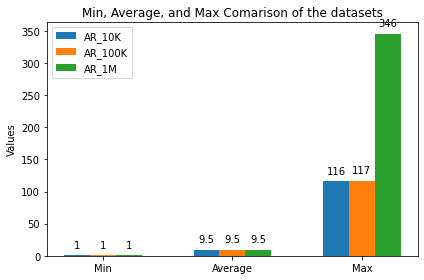

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Min', 'Average', 'Max']
AR_10K_data = find_stat(AR_list_10K)
AR_100K_data = find_stat(AR_list_100K)
AR_1M_data = find_stat(AR_list_1M)

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, AR_10K_data, width, label='AR_10K')
rects2 = ax.bar(x, AR_100K_data, width, label='AR_100K')
rects3 = ax.bar(x + width, AR_1M_data, width, label='AR_1M')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Min, Average, and Max Comarison of the datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=5)
ax.bar_label(rects2, padding=5)
ax.bar_label(rects3, padding=5)

fig.tight_layout()

plt.show()

## Pick Query

In [ ]:
# Generate a random number to select a query
index = random.randint(1, 10000) # random.randint(numLow, numHigh)
query = AR_list_10K[index]
print(index, query)

9353 Add remove items too slow and clunky Back to cart after a change should say do - not still add to cart..implies another item to order


In [ ]:
# Replace tokens with synonyms

query_tokens = query.split()

token_indices = get_n_rand_nums(0, len(query_tokens), int(len(query_tokens) / 4))

for i in token_indices:
    # get all the synonyms list
    synonyms = []
    for syn in wordnet.synsets(query_tokens[i]):
        for l in syn.lemmas():
            synonyms.append(l.name())
            # if l.antonyms():
                # antonyms.append(l.antonyms()[0].name())

    # randomly choose one synonym
    len_syn_lst = len(synonyms)
    if len_syn_lst > 0:
        idx = random.randint(0, len_syn_lst)
        query_tokens[i] = synonyms[idx]

syn_query = ' '.join(query_tokens)
print(query)
print(syn_query)

After the first 5 minutes, I knew I was hooked. Enchanting
After the first quintuplet minutes, I knew I was hooked. enamor


In [ ]:
# get paraphrase

paraphrases_lst = get_paraphrase(query, 20, 20)

# randomly choose one paraphrase
idx = random.randint(0, len(paraphrases_lst))

paraphrase_query = paraphrases_lst[idx]
print(paraphrase_query)

I knew I was hooked after the first few minutes.


In [ ]:
query = 'After the first 5 minutes, I knew I was hooked. Enchanting'
syn_query= 'After the first quintuplet minutes, I knew I was hooked. enamor'
paraphrase_query = 'I knew I was hooked after the first few minutes.'

# Applied Algorithms

## Lexical Analysis

### Okapi BM25

In [ ]:
# OkapiBM25
from rank_bm25 import BM25Okapi
import timeit

def find_match_bm25okapi(query, lst, num_of_match):

    training_start = timeit.default_timer()

    tokenized_corpus = [doc.split(' ') for doc in lst]
    okapi_bm25 = BM25Okapi(tokenized_corpus)

    training_stop = timeit.default_timer()

    test_start = timeit.default_timer()

    tokenized_query = query.split(' ')
    doc_scores = okapi_bm25.get_scores(tokenized_query)

    result_dict = {}
    result_dict['matches'] =  okapi_bm25.get_top_n(tokenized_query, lst, n=num_of_match)

    test_stop = timeit.default_timer()
    result_dict['training_time'] = training_stop - training_start
    result_dict['testing_time'] = test_stop - test_start

    return result_dict

In [ ]:
result = find_match_bm25okapi(query, AR_list_10K, 10)
print(result)

result = find_match_bm25okapi(query, AR_list_100K, 10)
print(result)

result = find_match_bm25okapi(query, AR_list_1M, 10)
print(result)

{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After the first order came in, I was hooked.', 'After the first time I had problems when I downloaded it, it was better. Very good now.', 'A friend recommended this game to me and I am hooked.', 'A fun short or long session decision making game. The first was good, I', 'All it does is crash. I get to play it for 5 or 10 minutes, then it crashes again!!! Please fix this!!!', 'A little confusing at first but I like the idea!', 'After I used it once my bank account was hacked', 'After i watched My 1st video I was in love', 'After hearing the story behind this game and the original that was created by another developer I have deleted candy crush saga from all 5 of the devices I played it on.'], 'training_time': 0.0807824610001262, 'testing_time': 0.04889445000026171}
{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After the first order came in, I was hooked.', 'After first use I give it 

### BM25L

In [ ]:
from rank_bm25 import BM25L
import timeit

def find_match_bm25l(query, lst, num_of_match):

    training_start = timeit.default_timer()

    tokenized_corpus = [doc.split(' ') for doc in lst]
    bm25l = BM25Okapi(tokenized_corpus)

    training_stop = timeit.default_timer()

    test_start = timeit.default_timer()

    tokenized_query = query.split(' ')
    doc_scores = bm25l.get_scores(tokenized_query)

    result_dict = {}
    result_dict['matches'] =  bm25l.get_top_n(tokenized_query, lst, n=num_of_match)

    test_stop = timeit.default_timer()
    result_dict['training_time'] = training_stop - training_start
    result_dict['testing_time'] = test_stop - test_start

    return result_dict

In [ ]:
result = find_match_bm25l(query, AR_list_10K, 10)
print(result)

result = find_match_bm25l(query, AR_list_100K, 10)
print(result)

result = find_match_bm25l(query, AR_list_1M, 10)
print(result)

{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After the first order came in, I was hooked.', 'After the first time I had problems when I downloaded it, it was better. Very good now.', 'A friend recommended this game to me and I am hooked.', 'A fun short or long session decision making game. The first was good, I', 'All it does is crash. I get to play it for 5 or 10 minutes, then it crashes again!!! Please fix this!!!', 'A little confusing at first but I like the idea!', 'After I used it once my bank account was hacked', 'After i watched My 1st video I was in love', 'After hearing the story behind this game and the original that was created by another developer I have deleted candy crush saga from all 5 of the devices I played it on.'], 'training_time': 0.07910307200017996, 'testing_time': 0.0514426679992539}
{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After the first order came in, I was hooked.', 'After first use I give it 

### BM25Plus

In [ ]:
from rank_bm25 import BM25Plus
import timeit

def find_match_bm25plus(query, lst, num_of_match):

    training_start = timeit.default_timer()

    tokenized_corpus = [doc.split(' ') for doc in lst]
    bm25plus = BM25Okapi(tokenized_corpus)

    training_stop = timeit.default_timer()

    test_start = timeit.default_timer()

    tokenized_query = query.split(' ')
    doc_scores = bm25plus.get_scores(tokenized_query)

    result_dict = {}
    result_dict['matches'] =  bm25plus.get_top_n(tokenized_query, lst, n=num_of_match)

    test_stop = timeit.default_timer()
    result_dict['training_time'] = training_stop - training_start
    result_dict['testing_time'] = test_stop - test_start

    return result_dict

In [ ]:
result = find_match_bm25plus(query, AR_list_10K, 10)
print(result)

result = find_match_bm25plus(query, AR_list_100K, 10)
print(result)

result = find_match_bm25plus(query, AR_list_1M, 10)
print(result)

{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After the first order came in, I was hooked.', 'After the first time I had problems when I downloaded it, it was better. Very good now.', 'A friend recommended this game to me and I am hooked.', 'A fun short or long session decision making game. The first was good, I', 'All it does is crash. I get to play it for 5 or 10 minutes, then it crashes again!!! Please fix this!!!', 'A little confusing at first but I like the idea!', 'After I used it once my bank account was hacked', 'After i watched My 1st video I was in love', 'After hearing the story behind this game and the original that was created by another developer I have deleted candy crush saga from all 5 of the devices I played it on.'], 'training_time': 0.08237174499936373, 'testing_time': 0.052850379000119574}
{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After the first order came in, I was hooked.', 'After first use I give i

### Rabin-Karp Pattern Searching

In [ ]:
# 1st Implementation (part a)

import random

def primesInRange(x, y):
    prime_list = []
    for n in range(x, y):
        isPrime = True

        for num in range(2, n):
            if n % num == 0:
                isPrime = False
                
        if isPrime:
            prime_list.append(n)
    return prime_list

In [ ]:
# 1st Implementation (part b)
d = 10

def find_match_count_rabin_karp(pattern, text, q):
    m = len(pattern)
    n = len(text)
    p = 0
    t = 0
    h = 1
    i = 0
    j = 0
    len_text = len(text)

    for i in range(m-1):
        h = (h*d) % q

    # Calculate hash value for pattern and text
    for i in range(m):
        p = (d*p + ord(pattern[i])) % q
        if i < len_text :
            t = (d*t + ord(text[i])) % q

    # Find the match
    count = 0
    for i in range(n-m+1):
        if p == t:
            for j in range(m):
                if text[i+j] != pattern[j]:
                    break

            j += 1
            if j == m:
                # print("Pattern is found at position: " + str(i+1))
                count += 1

        if i < n-m:
            t = (d*(t-ord(text[i])*h) + ord(text[i+m])) % q

            if t < 0:
                t = t+q

    return count

In [ ]:
# 1st Implementation (part c)

import timeit

def find_match_simple_rabin_karp(query, lst, num_of_matches):

    start = timeit.default_timer()

    plagiarism_rate = []

    query_len = len(query)
    for txt in lst:
        # print(txt)
        prime_list = primesInRange(1,200)
        randomPrime = random.choice(prime_list)
        if query_len < len(txt):
            plagiarism_rate.append(find_match_count_rabin_karp(query, txt, randomPrime))
        else:
            plagiarism_rate.append(find_match_count_rabin_karp(txt, query, randomPrime))
    
    # get the indices of grestest num_of_matches
    indices = sorted(range(len(plagiarism_rate)), key=lambda i: plagiarism_rate[i], reverse=True)[:num_of_matches]

    matches = []
    for idx in indices:
        matches.append(lst[idx])

    stop = timeit.default_timer()

    result_dict = {}
    result_dict['matches'] = matches
    result_dict['runtime'] = stop - start
    
    return result_dict

In [ ]:
# 2nd Implementation (part a)

class rolling_hash:
    def __init__(self, text, patternSize):
        self.text = text
        self.patternSize = patternSize
        self.base = 26
        self.window_start = 0
        self.window_end = 0
        self.mod = 5807
        self.hash = self.get_hash(text, patternSize)

    def get_hash(self, text, patternSize):
        hash_value = 0
        text_len = len(self.text)
        for i in range(0, patternSize):
            if i < text_len:
                hash_value += (ord(self.text[i]) - 96)*(self.base**(patternSize - i -1)) % self.mod

        self.window_start = 0
        self.window_end =  patternSize

        return hash_value
    def next_window(self):
        if self.window_end <= len(self.text) - 1:
            self.hash -= (ord(self.text[self.window_start]) - 96)*self.base**(self.patternSize-1)
            self.hash *= self.base
            self.hash += ord(self.text[self.window_end])- 96
            self.hash %= self.mod
            self.window_start += 1
            self.window_end += 1
            return True
        return False
    def current_window_text(self):
        return self.text[self.window_start:self.window_end]

def checker(text, pattern):
    if text == "" or pattern == "":
        return None
    if len(pattern) > len(pattern):
        return None

    text_rolling = rolling_hash(text, len(pattern))
    pattern_rolling = rolling_hash(pattern, len(pattern))


    for _ in range(len(text) -  len(pattern) - 1):
        if text_rolling.hash == pattern_rolling.hash:
            return "Found"
        text_rolling.next_window()
    return "Not Found"

In [ ]:
# 2nd Implementation (part b)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import numpy as np
from os.path import dirname, join


class PlagiarismChecker:
   def __init__(self, pattern, text):
       # self.file_a = file_a
       # self.file_b = file_b
       self.hash_table = {"a": [], "b": []}
       self.k_gram = 5
       content_a = pattern
       content_b = text
       self.calculate_hash(content_a, "a")
       self.calculate_hash(content_b, "b")
       
   # calaculate hash value of the file content
   # and add it to the document type hash table 
   def calculate_hash(self, content, doc_type):
       text = self.prepare_content(content)
       text = "".join(text)

       text = rolling_hash(text, self.k_gram)
       for _ in range(len(content) - self.k_gram + 1):
           self.hash_table[doc_type].append(text.hash)
           if text.next_window() == False:
               break

   def get_rate(self):
       return self.calaculate_plagiarism_rate(self.hash_table)
     
   # calculate the plagiarism rate using the plagiarism rate formula
   def calaculate_plagiarism_rate(self, hash_table):
       th_a = len(hash_table["a"])
       th_b = len(hash_table["b"])
       a = hash_table["a"]
       b = hash_table["b"]
       sh = len(np.intersect1d(a, b))
       # print(sh, a, b)

       # Formular for plagiarism rate
       # P = (2 * SH / THA * THB ) 100%
       p = (float(2 * sh)/(th_a + th_b)) * 100
       return p
     
   # get content from file
   def get_file_content(self, filename):
       file = open(filename, 'r+', encoding="utf-8")
       return file.read()
     
   # Prepare content by removing stopwords, steemming and tokenizing 
   def prepare_content(self, content):
       # STOP WORDS
       stop_words = set(stopwords.words('english'))
       # TOKENIZE
       word_tokens = word_tokenize(content)
       filtered_content = []
       # STEMMING
       porter = PorterStemmer()
       for w in word_tokens:
           if w not in stop_words:
               w = w.lower()
               word = porter.stem(w)
               filtered_content.append(word)

       return filtered_content

In [ ]:
# 2nd Implementation (part c)
import timeit

def find_match_rabin_karp_2(query, lst, num_of_matches):

    start = timeit.default_timer()

    plagiarism_rate = []

    query_len = len(query)
    for txt in lst:
        if query_len < len(txt):
            plagiarism_rate.append(PlagiarismChecker(query, txt).get_rate())
        else:
            plagiarism_rate.append(PlagiarismChecker(txt, query).get_rate())
    
    # get the indices of grestest num_of_matches
    indices = sorted(range(len(plagiarism_rate)), key=lambda i: plagiarism_rate[i], reverse=True)[:num_of_matches]

    matches = []
    for idx in indices:
        matches.append(lst[idx])

    stop = timeit.default_timer()

    result_dict = {}
    result_dict['matches'] = matches
    result_dict['runtime'] = stop - start
    
    return result_dict

In [ ]:
result = find_match_simple_rabin_karp(query, AR_list_10K, 10)
print(result)

result = find_match_simple_rabin_karp(query, AR_list_100K, 10)
print(result)

result = find_match_simple_rabin_karp(query, AR_list_1M, 10)
print(result)

{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'Adobe just bombarded  me to sign up to monthly plan to much', 'all for free...:-)', 'A good game fabulous', 'Addictive and fun for free', 'Add Notification tab To notify about restock of item which is not available now', 'All my files in one place', 'Addictive game to keep guys idle free', 'Addictive. Love it. Hate all the ads!', 'Addictive game u must try it'], 'runtime': 10.446224581000024}
{'matches': ['After the', 'After the first 5 minutes, I knew I was hooked. Enchanting', 'Addictive as all ....', 'Addictive And Relaxing', 'After installing it says due to limitations of Android 6 and 6.1, all Caches have to be cleaned manually.       Still', 'Ads are riddled in ever minute of the game and its overall very repetitive.', 'A little hard to join', 'A GREAT WAY TO GET INTO THE WORD!', 'A gi', 'All I need is endless scrolling'], 'runtime': 105.02678786300021}
{'matches': ['Aft', 'After', 'After t', 'After the',

In [ ]:
result = find_match_rabin_karp_2(query, AR_list_10K, 10)
print(result)

result = find_match_rabin_karp_2(query, AR_list_100K, 10)
print(result)

result = find_match_rabin_karp_2(query, AR_list_1M, 10)
print(result)

{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After the first order came in, I was hooked.', 'After the first world you have to pay money', 'After its first update its getting better and better than before', 'After first payment score went up 10 points!!!!!!!', 'After first checking this out in 2017,it still was a waste of time after 3 years...', 'After the first time I had problems when I downloaded it, it was better. Very good now.', 'After the first stage you need to buy more stages and that to be 800 rupees.. Are you kidding me..', 'Allot better then the first great game', 'Add within the first minute, why bother'], 'runtime': 11.171251691999942}
{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After the first order came in, I was hooked.', 'After the first 5 minutes I felt calm and relaxed. You must try to clear your mind as you breathe.', 'After first product', 'After the first win its boring', 'After the first fight it shu

### Finite Automata algorithm for Pattern Searching

In [ ]:
NO_OF_CHARS = 512
  
def getNextState(pat, M, state, x):
    # calculate the next state 

    # If the character c is same as next character in pattern, then simply increment state
  
    if state < M and x == ord(pat[state]):
        return state+1
  
    i=0
    # ns stores the result which is next state
  
    # ns finally contains the longest prefix which is also suffix in "pat[0..state-1]c"
  
    # Start from the largest possible value and stop when you find a prefix which is also suffix
    for ns in range(state,0,-1):
        if ord(pat[ns-1]) == x:
            while(i<ns-1):
                if pat[i] != pat[state-ns+1+i]:
                    break
                i+=1
            if i == ns-1:
                return ns 
    return 0
  
def computeTF(pat, M):
    # This function builds the TF table which represents Finite Automata for a given pattern
    
    global NO_OF_CHARS
  
    TF = [[0 for i in range(NO_OF_CHARS)]\
          for _ in range(M+1)]
  
    for state in range(M+1):
        for x in range(NO_OF_CHARS):
            z = getNextState(pat, M, state, x)
            TF[state][x] = z
  
    return TF
  
def search_FA(pat, txt):
    # Prints all occurrences of pat in txt

    global NO_OF_CHARS
    M = len(pat)
    N = len(txt)
    TF = computeTF(pat, M)    
  
    # Process txt over FA.
    state=0
    count = 0
    for i in range(N):
        if i < len(txt)  and ord(txt[i]) < len(TF[state]):
            state = TF[state][ord(txt[i])]
        if state == M:
            # print("Pattern found at index: {}".format(i-M+1))
            count += 1
    
    return count

In [ ]:
import timeit

def find_match_FA(query, lst, num_of_matches):

    start = timeit.default_timer()

    plagiarism_rate = []

    query_len = len(query)
    for txt in lst:
        if query_len < len(txt):
            plagiarism_rate.append(search_FA(query, txt))
        else:
            plagiarism_rate.append(search_FA(txt, query))
    
    # get the indices of grestest num_of_matches
    indices = sorted(range(len(plagiarism_rate)), key=lambda i: plagiarism_rate[i], reverse=True)[:num_of_matches]

    matches = []
    for idx in indices:
        matches.append(lst[idx])

    stop = timeit.default_timer()

    result_dict = {}
    result_dict['matches'] = matches
    result_dict['runtime'] = stop - start
    
    return result_dict

In [ ]:
# result = find_match_FA(query, AR_list_10K, 10)
# print(result) # {'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'Adobe just bombarded  me to sign up to monthly plan to much', 'all for free...:-)', 'A good game fabulous', 'Addictive and fun for free', 'Add Notification tab To notify about restock of item which is not available now', 'All my files in one place', 'Addictive game to keep guys idle free', 'Addictive. Love it. Hate all the ads!', 'Addictive game u must try it'], 'runtime': 561.2690124179999}

result = find_match_FA(query, AR_list_100K, 10)
print(result)

result = find_match_FA(query, AR_list_1M, 10)
print(result)

### Boyer Moore Algorithm

In [ ]:
# Python3 Program for Bad Character Heuristic of Boyer Moore String Matching Algorithm
 
NO_OF_CHARS = 512
 
def badCharHeuristic(string, size):
    # The preprocessing function for Boyer Moore's bad character heuristic
 
    # Initialize all occurrence as -1
    badChar = [-1]*NO_OF_CHARS
 
    # Fill the actual value of last occurrence
    for i in range(size):
        if ord(string[i]) < len(badChar):
            badChar[ord(string[i])] = i
 
    # retun initialized list
    return badChar
 
def search_BM(txt, pat):
    # A pattern searching function that uses Bad Character Heuristic of Boyer Moore Algorithm
    
    m = len(pat)
    n = len(txt)
 
    # create the bad character list by calling the preprocessing function badCharHeuristic() for given pattern
    badChar = badCharHeuristic(pat, m)
 
    # s is shift of the pattern with respect to text
    s = 0
    count = 0
    while(s <= n-m):
        j = m-1
 
        # Keep reducing index j of pattern while characters of pattern and text are matching at this shift s
        while j>=0 and pat[j] == txt[s+j]:
            j -= 1

        # If the pattern is present at current shift, then index j will become -1 after the above loop
        if j<0:
            # print("Pattern occur at shift = {}".format(s))
            count += 1
                # Shift the pattern so that the next character in text aligns with the last occurrence of it in pattern.
                # The condition s+m < n is necessary for the case when pattern occurs at the end of text
                
            s += (m-badChar[ord(txt[s+m])] if s+m<n else 1)
        else:
               # Shift the pattern so that the bad character in text aligns with the last occurrence of it in pattern. 
               # The max function is used to make sure that we get a positive shift. 
               # We may get a negative shift if the last occurrence of bad character in pattern is on the right side of the current character.
               
            s += max(1, j-badChar[ord(txt[s+j])])

    return count

In [ ]:
import timeit

def find_match_BM(query, lst, num_of_matches):

    start = timeit.default_timer()

    plagiarism_rate = []

    query_len = len(query)
    for txt in lst:
        if query_len < len(txt):
            plagiarism_rate.append(search_BM(query, txt))
        else:
            plagiarism_rate.append(search_BM(txt, query))
    
    # get the indices of grestest num_of_matches
    indices = sorted(range(len(plagiarism_rate)), key=lambda i: plagiarism_rate[i], reverse=True)[:num_of_matches]

    matches = []
    for idx in indices:
        matches.append(lst[idx])

    stop = timeit.default_timer()

    result_dict = {}
    result_dict['matches'] = matches
    result_dict['runtime'] = stop - start
    
    return result_dict

In [ ]:
result = find_match_BM(query, AR_list_10K, 10)
print(result)

result = find_match_BM(query, AR_list_100K, 10)
print(result)

result = find_match_BM(query, AR_list_1M, 10)
print(result)

{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'Adobe just bombarded  me to sign up to monthly plan to much', 'all for free...:-)', 'A good game fabulous', 'Addictive and fun for free', 'Add Notification tab To notify about restock of item which is not available now', 'All my files in one place', 'Addictive game to keep guys idle free', 'Addictive. Love it. Hate all the ads!', 'Addictive game u must try it'], 'runtime': 0.22381487699999525}
{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'Addictive as all ....', 'Addictive And Relaxing', 'After installing it says due to limitations of Android 6 and 6.1, all Caches have to be cleaned manually.       Still', 'Ads are riddled in ever minute of the game and its overall very repetitive.', 'A little hard to join', 'A GREAT WAY TO GET INTO THE WORD!', 'A gi', 'All I need is endless scrolling', 'A great delivery of information across countries.'], 'runtime': 2.2184684240000365}
{'matches':

### Aho-Corasick Algorithm for Pattern Searching

In [ ]:
!pip install pyahocorasick

     |████████████████████████████████| 327kB 7.1MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85398 sha256=afbf5d8b0eca14e531aeea626c5419336434dd99616a439097b97276ceff0eb9
  Stored in directory: /root/.cache/pip/wheels/3a/03/34/77e3ece0bba8b86bfac88a79f923b36d805cad63caeba38842
Successfully built pyahocorasick


In [ ]:
import timeit
import ahocorasick

def find_match_AC(query, lst, num_of_matches):

    start = timeit.default_timer()

    plagiarism_rate = []

    
    query_tokens = query.split()
    
    for txt in lst:
        txt_tokens = txt.split()
        i = 0
        count = 0
        for token in query_tokens:
            A = ahocorasick.Automaton()
            for idx, key in enumerate(txt_tokens[i:]):
                A.add_word(key, (idx, key))
            if token in A:
                count += 1
            i += 1
        plagiarism_rate.append(count/len(query_tokens))
    
    # get the indices of grestest num_of_matches
    indices = sorted(range(len(plagiarism_rate)), key=lambda i: plagiarism_rate[i], reverse=True)[:num_of_matches]

    matches = []
    for idx in indices:
        matches.append(lst[idx])

    stop = timeit.default_timer()

    result_dict = {}
    result_dict['matches'] = matches
    result_dict['runtime'] = stop - start
    
    return result_dict

In [ ]:
result = find_match_AC(query, AR_list_10K, 10)
print(result)

result = find_match_AC(query, AR_list_100K, 10)
print(result)

result = find_match_AC(query, AR_list_1M, 10)
print(result)

{'matches': ['After the first 5 minutes, I knew I was hooked. Enchanting', 'After playing the first one and finishing it, I felt it was a little short. But, this one is just on another level, hours of fun! This is a must buy if you like puzzle games.', 'After the first time I had problems when I downloaded it, it was better. Very good now.', 'After hearing the story behind this game and the original that was created by another developer I have deleted candy crush saga from all 5 of the devices I played it on.', 'After the update my loading screen wont get passed 88%. Even before that, loading time was 5 minutes each time I wanted to play the game. Please fix as I do like the game.', 'After the first 100 nothing new to keep me interested. And just when I thought the dark mode was going to pull me back in they made it micro transaction hades.', 'After the latest update the game no longer loads at all. It just remains stuck on the start screen with the music playing in the background and 

# Different Text Similarity Metrics

## Functions


### Dataset Creation

In [ ]:
wikipedia_lst = [
                "A transformer is a deep learning model that adopts the mechanism of attention, differentially weighing the significance of each part of the input data. It is used primarily in the field of natural language processing (NLP) and in computer vision (CV).",
                "Like recurrent neural networks (RNNs), transformers are designed to handle sequential input data, such as natural language, for tasks such as translation and text summarization. However, unlike RNNs, transformers do not necessarily process the data in order. Rather, the attention mechanism provides context for any position in the input sequence. For example, if the input data is a natural language sentence, the transformer does not need to process the beginning of the sentence before the end. Rather, it identifies the context that confers meaning to each word in the sentence. This feature allows for more parallelization than RNNs and therefore reduces training times.",
                "Transformers are the model of choice for NLP problems, replacing RNN models such as long short-term memory (LSTM). The additional training parallelization allows training on larger datasets than was once possible. This led to the development of pretrained systems such as BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pre-trained Transformer), which were trained with large language datasets, such as Wikipedia Corpus and Common Crawl, and can be fine-tuned for specific tasks.",
                "Before transformers, most state-of-the-art NLP systems relied on gated RNNs, such as LSTM and gated recurrent units (GRUs), with added attention mechanisms. Transformers built on these attention technologies without using an RNN structure, highlighting the fact that attention mechanisms alone can match the performance of RNNs with attention.",
                "Gated RNNs process tokens sequentially, maintaining a state vector that contains a representation of the data seen after every token. To process the n-th token, the model combines the state representing the sentence up to token n-1 with the information of the new token to create a new state, representing the sentence up to token n. Theoretically, the information from one token can propagate arbitrarily far down the sequence, if at every point the state continues to encode contextual information about the token. In practice this mechanism is flawed: the vanishing gradient problem leaves the model's state at the end of a long sentence without precise, extractable information about preceding tokens.",
                "This problem was addressed by attention mechanisms. Attention mechanisms let a model draw from the state at any preceding point along the sequence. The attention layer can access all previous states and weighs them according to a learned measure of relevancy, providing relevant information about far-away tokens.",
                "A clear example of the value of attention is in language translation, where context is essential to assigning the meaning of a word in a sentence. In an English-to-French translation system, the first word of the French output most probably depends heavily on the first few words of the English input. However, in a classic LSTM model, in order to produce the first word of the French output, the model is given only the state vector of the last English word. Theoretically, this vector can encode information about the whole English sentence, giving the model all necessary knowledge. In practice this information is often poorly preserved by the LSTM. An attention mechanism can be added to address this problem: the decoder is given access to the state vectors of every English input word, not just the last, and can learn attention weights that dictate how much to attend to each English input state vector.",
                "When added to RNNs, attention mechanisms increase performance. The development of the Transformer architecture revealed that attention mechanisms were powerful in themselves, and that sequential recurrent processing of data was not necessary to achieve the performance gains of RNNs with attention. Transformers use an attention mechanism without an RNN, processing all tokens at the same time and calculating attention weights between them in successive layers.",
                "Like earlier models, the transformer adopts an encoder-decoder architecture. The encoder consists of encoding layers that process the input iteratively one layer after another, while the decoder consists of decoding layers that do the same thing to the encoder's output.",
                "The function of each encoder layer is to generate encodings that contain information about which parts of the inputs are relevant to each other. It passes its encodings to the next encoder layer as inputs. Each decoder layer does the opposite, taking all the encodings and using their incorporated contextual information to generate an output sequence. To achieve this, each encoder and decoder layer makes use of an attention mechanism.",
                "For each input, attention weighs the relevance of every other input and draws from them to produce the output. Each decoder layer has an additional attention mechanism that draws information from the outputs of previous decoders, before the decoder layer draws information from the encodings."
                "Both the encoder and decoder layers have a feed-forward neural network for additional processing of the outputs, and contain residual connections and layer normalization steps.",
                "The transformer building blocks are scaled dot-product attention units. When a sentence is passed into a transformer model, attention weights are calculated between every token simultaneously. The attention unit produces embeddings for every token in context that contain information about the token itself along with a weighted combination of other relevant tokens each weighted by its attention weight."
]
# wikipedia_lst[11]

'The transformer building blocks are scaled dot-product attention units. When a sentence is passed into a transformer model, attention weights are calculated between every token simultaneously. The attention unit produces embeddings for every token in context that contain information about the token itself along with a weighted combination of other relevant tokens each weighted by its attention weight.'

In [ ]:
import random

line_num = random.randint(0, len(wikipedia_lst)-1)
key = wikipedia_lst[line_num]
print(key)

Like earlier models, the transformer adopts an encoder-decoder architecture. The encoder consists of encoding layers that process the input iteratively one layer after another, while the decoder consists of decoding layers that do the same thing to the encoder's output.


### Second Dataset with multiple input paragraphs that we would like to plagiarize

In [ ]:
dataset_lst = ["In 2015, after the death of Freddie Gray in Baltimore, Maryland, black activists around the world modeled efforts for reform on Black Lives Matter and the Arab Spring.",
"Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people. While there are specific organizations such as the Black Lives Matter Global Network that labels themselves simply as \"Black Lives Matter\", the Black Lives Matter movement comprises a broad array of people and organizations.",
"The slogan \"Black Lives Matter\" itself remains untrademarked by any group. The broader movement and its related organizations typically advocate against police violence toward black people as well as for various other policy changes considered to be related to black liberation. In July 2013, the movement began with the use of the hashtag #BlackLivesMatter on social media after the acquittal of George Zimmerman in the shooting death of African-American teen Trayvon Martin 17 months earlier in February 2012. The movement became nationally recognized for street demonstrations following the 2014 deaths of two African Americans, that of Michael Brown—resulting in protests and unrest in Ferguson, Missouri, a city near St. Louis—and Eric Garner in New York City.",
"Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people. While there are specific organizations such as the Black Lives Matter Global Network that labels themselves simply as \"Black Lives Matter\", the Black Lives Matter movement comprises a broad array of people and organizations. The slogan \"Black Lives Matter\" itself remains untrademarked by any group. The broader movement and its related organizations typically advocate against police violence toward black people as well as for various other policy changes considered to be related to black liberation. In July 2013, the movement began with the use of the hashtag #BlackLivesMatter on social media after the acquittal of George Zimmerman in the shooting death of African-American teen Trayvon Martin 17 months earlier in February 2012. The movement became nationally recognized for street demonstrations following the 2014 deaths of two African Americans, that of Michael Brown—resulting in protests and unrest in Ferguson, Missouri, a city near St. Louis—and Eric Garner in New York City.",
"The slogan \"Black Lives Matter\" itself remains untrademarked by any group. The broader movement and its related organizations typically advocate against police violence toward black people as well as for various other policy changes considered to be related to black liberation. In July 2013, the movement began with the use of the hashtag #BlackLivesMatter on social media after the acquittal of George Zimmerman in the shooting death of African-American teen Trayvon Martin 17 months earlier in February 2012. The movement became nationally recognized for street demonstrations following the 2014 deaths of two African Americans, that of Michael Brown—resulting in protests and unrest in Ferguson, Missouri, a city near St. Louis—and Eric Garner in New York City. Since the Ferguson protests, participants in the movement have demonstrated against the deaths of numerous other African Americans by police actions or while in police custody. In the summer of 2015, Black Lives Matter activists became involved in the 2016 United States presidential election. The originators of the hashtag and call to action, Alicia Garza, Patrisse Cullors, and Opal Tometi, expanded their project into a national network of over 30 local chapters between 2014 and 2016. The overall Black Lives Matter movement is a decentralized network of activists with no formal hierarchy.",
"The phrase \"Black Lives Matter\" can refer to a Twitter hashtag, a slogan, a social movement, a political action committee, or a loose confederation of groups advocating for racial justice. As a movement, Black Lives Matter is grassroots and decentralized, and leaders have emphasized the importance of local organizing over national leadership.The structure differs from previous black movements, like the Civil Rights Movement. Such differences have been the subject of scholarly literature. Activist DeRay McKesson has commented that the movement \"encompasses all who publicly declare that black lives matter and devote their time and energy accordingly.\" In 2013, Patrisse Cullors, Alicia Garza, and Opal Tometi formed the Black Lives Matter Network. Garza described the network as an online platform that existed to provide activists with a shared set of principles and goals. Local Black Lives Matter chapters are asked to commit to the organization's list of guiding principles but operate without a central structure or hierarchy. Garza has commented that the Network was not interested in \"policing who is and who is not part of the movement.\" The loose structure of Black Lives Matter has contributed to confusion in the press and among activists, as actions or statements from chapters or individuals are sometimes attributed to \"Black Lives Matter\" as a whole.",
"Concurrently, a broader movement involving several other organizations and activists emerged under the banner of \"Black Lives Matter\", as well. In 2015, Johnetta Elzie, DeRay McKesson, Brittany Packnett, and Samuel Sinyangwe initiated Campaign Zero, aimed at promoting policy reforms to end police brutality. The campaign released a ten-point plan for reforms to policing, with recommendations including ending broken windows policing, increasing community oversight of police departments, and creating stricter guidelines for the use of force. The New York Times reporter, John Eligon, wrote that some activists expressed concerns that the campaign was overly focused on legislative remedies for police violence. Black Lives Matter also voices support for movements and causes outside of black police brutality, including LGBTQ activism, feminism, immigration reform, and economic justice. The Movement for Black Lives (M4BL) is a coalition of more than 50 groups representing the interests of black communities across the United States. Members include the Black Lives Matter Network, the National Conference of Black Lawyers, and the Ella Baker Center for Human Rights. Endorsed by groups such as Color of Change, Race Forward, Brooklyn Movement Center, PolicyLink, Million Women March Cleveland, and ONE DC, the coalition receives communications and tactical support from an organization named Blackbird. Following the murder of George Floyd, M4BL released the BREATHE Act, which called for sweeping legislative changes surrounding policing; the policy bill included calls to divest from policing and reinvest funds directly in community resources and alternative emergency response models. On July 24, 2015 the movement initially convened at Cleveland State University where between 1,500 and 2,000 activists gathered to participate in open discussions and demonstrations. The conference in Cleveland, Ohio initially attempted to \"strategize ways for the Movement for Black Lives to hold law enforcement accountable for their actions on a national level\". However, the conference resulted in the formation of a much more significant social movement.",
"At the end of the three-day conference, on July 26, the Movement for Black Lives initiated a year-long \"process of convening local and national groups to create a United Front\". This year-long process ultimately resulted in the establishment of an organizational platform that articulates the goals, demands, and policies that the Movement for Black Lives supports in order to achieve the \"liberation\" of black communities across America. In 2016, the Ford Foundation announced plans to fund the M4BL Movement For Black Lives in a \"six-year investments\" plan, further partnering up with others to found the Black-led Movement Fund. The sum donated by the Ford Foundation and the other donors to M4BL was reported as $100 million by The Washington Times in 2016; another donation of $33 million to M4BL was reportedly issued by the Open Society Foundations. In 2016, M4BL called for decarceration in the United States, reparations for harms related to slavery, and more recently, specific remedies for redlining in housing, education policy, mass incarceration, and food insecurity. It also called for an end to mass surveillance, investment in public education, not incarceration, and community control of the police: empowering residents in communities of color to hire and fire police officers and issue subpoenas, decide disciplinary consequences, and exercise control over city funding of police. Politico reported in 2015 that the Democracy Alliance, a gathering of Democratic-Party donors, planned to meet with leaders of several groups who were endorsing the Black Lives Matter movement. According to Politico, Solidaire, the donor coalition focusing on \"movement building\" and led by Texas oil fortune heir Leah Hunt-Hendrix, a member of the Democracy Alliance, had donated more than $200,000 to the BLM movement by 2015. According to The Economist, between May 2020 and December 2020, donations to Black Lives Matter related causes amounted to $10.6 billion dollars The Black Lives Matter Global Network Foundation, one of the main organizations coordinating organizing and mobilization efforts across the Black Lives Matter network, reported raising $90 million in 2020, including a substantial number of individual donations online, with an average donation of $30.76. Black Lives Matter originally used various social media platforms—including hashtag activism—to reach thousands of people rapidly. Since then, Black Lives Matter has embraced a diversity of tactics. Black Lives Matter protests have been overwhelmingly peaceful; when violence does occur, it is often committed by police or by counter-protesters. Despite this, opponents have falsely portrayed the movement as violent. In 2014, the American Dialect Society chose #BlackLivesMatter as their word of the year.",
"Yes! Magazine picked #BlackLivesMatter as one of the twelve hashtags that changed the world in 2014. From July 2013 through May 1, 2018, the hashtag \"#BlackLivesMatter\" had been tweeted over 30 million times, an average of 17,002 times per day. By June 10, 2020, it had been tweeted roughly 47.8 million times, with the period of July 7–17, 2016 having the highest usage, at nearly 500,000 tweets a day. This period also saw an increase in tweets using the hashtags \"#BlueLivesMatter\" and \"#AllLivesMatter\". On May 28, 2020, there were nearly 8.8 million tweets with the hashtag, and the average had increased to 3.7 million a day. The 2016 shooting of Dallas police officers saw the online tone of the movement become more negative than before, with 39% of tweets using the hashtag #BlackLivesMatter expressing opposition to the movement. Nearly half in opposition tied the group to violence, with many describing the group as terrorists. Khadijah White, a professor at Rutgers University, argues that BLM has ushered in a new era of black university student movements. The ease with which bystanders can record graphic videos of police violence and post them onto social media has driven activism all over the world. The hashtag's usage has gained the attention of high-ranking politicians and has sometimes encouraged them to support the movement. On Wikipedia, a WikiProject dedicated to coverage of the Black Lives Matter movement was created in June 2020. In 2020, users of the popular app TikTok noticed that the app seemed to be shadow-banning posts about BLM or recent police killings of black people. TikTok apologized and attributed the situation to a technical glitch. BLM generally engages in direct action tactics that make people uncomfortable enough that they must address the issue. BLM has been known to build power through protests and rallies. BLM has also staged die-ins and held one during the 2015 Twin Cities Marathon.",
"Political slogans used during demonstrations include the eponymous \"Black Lives Matter\", \"Hands up, don't shoot\" (a later discredited reference attributed to Michael Brown), \"I can't breathe\" (referring to Eric Garner and later George Floyd), \"White silence is violence\", \"No justice, no peace\", and \"Is my son next?\", among others. According to a 2018 study, \"Black Lives Matter protests are more likely to occur in localities where more black people have previously been killed by police.\" Since the beginning of the Black Lives Matter movement in 2013, with the hashtag #BlackLivesMatter, the movement has been depicted and documented in the film, song, television, literature, and the visual arts. A number of media outlets are providing material related to racial injustice and the Black Lives Matter movement. Published books, novels, and TV shows have increased in popularity in 2020. Songs, such as Michael Jackson's \"They Don't Care About Us\" and Kendrick Lamar's \"Alright\", have been widely used as a rallying call at demonstrations. The short documentary film, Bars4justice, features brief appearances by various activists and recording artists affiliated with the Black Lives Matter movement. The film is an official selection of the 24th Annual Pan African Film Festival. Stay Woke: The Black Lives Matter Movement is a 2016 American television documentary film, starring Jesse Williams, about the Black Lives Matter movement. The February 2015 issue of Essence magazine and the cover was devoted to Black Lives Matter. In December 2015, BLM was a contender for the Time magazine Person of the Year award, coming in fourth of the eight candidates. A number of cities have painted murals of \"Black Lives Matter\" in large letters on their streets. The cities include Washington, D.C., Dallas, Denver, Charlotte, Seattle, Brooklyn, Los Angeles, and Birmingham, Alabama. On May 9, 2016, Delrish Moss was sworn in as the first African-American police chief in Ferguson, Missouri. He acknowledged that he faces such challenges as diversifying the police force, improving community relations, and addressing issues that catalyzed the Black Lives Matter movement. According to a study from the Bureau of Justice Statistics from 2002 to 2011, among those who had contact with the police, \"blacks (2.8%) were more likely than whites (1.0%) and Hispanics (1.4%) to perceive the threat or use of nonfatal force was excessive.\" According to The Washington Post, police officers shot and killed 1,001 people in the United States in 2019. About half of those killed were white, and one-quarter were black, making the rate of deaths for black Americans (31 fatal shootings per million) more than twice as high as the rate for white Americans (13 fatal shootings per million).",
"A 2019 study by Cesario et al. published in Social Psychological and Personality Science found that after adjusting for crime, there was \"no systematic evidence of anti-black disparities in fatal shootings, fatal shootings of unarmed citizens, or fatal shootings involving misidentification of harmless objects\". However, a 2020 study by Ross et al. criticizes the data analysis used in the Cesario et al. study. Using the same data set, Ross et al. conclude that there is significant racial bias in police shooting cases involving unarmed black suspects. This bias is not seen when suspects were armed. A study by Harvard economist Roland Fryer found that blacks and Hispanics were 50% more likely to experience non-lethal force in police interactions, but for officer-involved shootings there were \"no racial differences in either the raw data or when contextual factors are taken into account\". A study by C. Ross, UC Davis found \"significant bias in the killing of unarmed black Americans relative to unarmed white Americans\" by police. The average bias measure was that unarmed African Americans had 3.49 times the probability of being shot compared to unarmed whites, although in some jurisdictions the risk could be as much as 20 times higher. The study found that that 2.79 more armed blacks were shot than unarmed blacks. The study also found that the documented racial bias in police shootings could not be explained by differences in local crime rates. A since retracted study in PNAS claimed that black people were actually less likely than white people to be killed by police, based on the death rates in police encounters. A study published in the journal Nature that found such conclusions were erroneous due to Simpson's paradox. The Nature paper showed that it was true that white people were more likely to be killed in a police encounter, overall black people were still being discriminated against because they had far more interactions with the police due to structural racism. The paper noted that black people have far more interactions with the police per capita than white people, and that black people tend to get stopped for more petty crimes or for no crime at all. Conversely, white people tend to interact with police in situations more rarely, and often in more serious crimes such as shootings, where police are more likely to use force. The Nature paper also backed up the findings of Ross and Fryer, and concluded that overall rate of death was a much more useful statistic than the rate of death in encounters. In 2014, Black Lives Matter demonstrated against the deaths of numerous African Americans by police actions, including those of Dontre Hamilton, Eric Garner, John Crawford III, Michael Brown, Ezell Ford, Laquan McDonald, Akai Gurley, Tamir Rice, Antonio Martin, and Jerame Reid, among others. In July, Eric Garner died in New York City, after a New York City Police Department officer put him in a banned chokehold while arresting him. Garner's death has been cited as one of several police killings of African Americans that sparked the Black Lives Matter movement. During the Labor Day weekend in August, Black Lives Matter organized a \"Freedom Ride\", that brought more than 500 African-Americans from across the United States into Ferguson, Missouri, to support the work being done on the ground by local organizations. The movement continued to be involved in the Ferguson protests, following the death of Michael Brown."]

In [ ]:
import random

line_num = random.randint(0, len(dataset_lst)-1)
line_num=1
key = dataset_lst[line_num]
print(line_num, key)

1 Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people. While there are specific organizations such as the Black Lives Matter Global Network that labels themselves simply as "Black Lives Matter", the Black Lives Matter movement comprises a broad array of people and organizations.


#### N-Word Synonym Swap

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from nltk.corpus import wordnet   
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string, math, random

def get_syn_swapped_key(key, n = 1, percent = False):
    print('Key:', key)
    tokens = word_tokenize(key)
    
    syns = {}               # Store results in a dict where key is token and value is a lexically different synonym
    ban_list = []           # unswappable token indices
    unswappable_count = 0   # number of unswappable tokens

    # prapare 'ban_list'    # count 'unswappable_count'    # create tokens_syns and syns
    index = 0
    stemmer = SnowballStemmer("english")
    for tok in tokens:
        term = tok.lower()

        synonyms = []
        for syn in wordnet.synsets(term):
            for l in syn.lemmas():
                synonyms.append(l.name())

        if (term in string.punctuation) or (term in stopwords.words('english')) or (len(synonyms) <= 1):
            unswappable_count = unswappable_count + 1
            ban_list.append(index)
        else:
            flag = False
            for j in synonyms:
                if term.lower() != j.lower() and stemmer.stem(term.lower()) != stemmer.stem(j.lower()):
                    syns[tok] = j
                    flag = True
                    break

            if flag == False:
                unswappable_count = unswappable_count + 1
                ban_list.append(index)
        
        index = index + 1
    
    # check if n is greater than the number of swappable tokens
    swappable_count = len(tokens) - unswappable_count
    if n <= swappable_count:

        # make the list containing synonyms of valid tokens
        indices = [*range(0, len(tokens), 1)]

        # get the random inex/indices except for the ones in 'ban_list'
        valid_list = [x for x in indices if x not in ban_list]  # indices - ban_list
        lst_indices_2_swap = random.sample(valid_list , n) if percent == False else random.sample(valid_list , int(math.ceil(swappable_count * (n/100))))
        
        # Change the tokens with valid synonyms
        for i in lst_indices_2_swap:
            print(tokens[i], '-->\t', syns[tokens[i]])
            tokens[i] = syns[tokens[i]]

        n_syn_swapped_key = ' '.join(tokens)
        print('N-Word Synonym Swapped Key:', n_syn_swapped_key)
        return n_syn_swapped_key
    
    else:
        print('N is greater than the number of swappable tokens present in the \'Key\'')

In [ ]:
n_syn_swapped_key = get_syn_swapped_key(key)            # 1 token will be replaced with synonyms
n_syn_swapped_key = get_syn_swapped_key(key, 15)        # 15 tokens will be replaced with synonyms
n_syn_swapped_key = get_syn_swapped_key(key, 60)        # N is greater than the number of swappable tokens present in the 'Key'
n_syn_swapped_key = get_syn_swapped_key(key, 25, True)  # 25% of swappable tokens will be replaced with synonyms

Key: Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people. While there are specific organizations such as the Black Lives Matter Global Network that labels themselves simply as "Black Lives Matter", the Black Lives Matter movement comprises a broad array of people and organizations.
Lives -->	 life
N-Word Synonym Swapped Key: Black Lives Matter ( BLM ) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people . While there are specific organizations such as the Black life Matter Global Network that labels themselves simply as `` Black Lives Matter '' , the Black Lives Matter movement comprises a broad array of people and organizations .
Key: Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and

#### Paragraph Addition

In [ ]:
import random

def get_para_added_key(key, n = 1):
    print('Key:', key)
    
    indices = [*range(0, len(dataset_lst), 1)]
    indices.remove(line_num)
    new_line_nums = random.sample(indices, n)
    para_added_key = key
    for i in new_line_nums:
        para_added_key = para_added_key + ' ' + dataset_lst[i]
    print(para_added_key)
    return para_added_key

In [ ]:
para_added_key = get_para_added_key(key, 2) # add 2 paragraphs at the end of the key
para_added_key = get_para_added_key(key)    # add one paragraph at the end of the key

Key: Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people. While there are specific organizations such as the Black Lives Matter Global Network that labels themselves simply as "Black Lives Matter", the Black Lives Matter movement comprises a broad array of people and organizations.
Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people. While there are specific organizations such as the Black Lives Matter Global Network that labels themselves simply as "Black Lives Matter", the Black Lives Matter movement comprises a broad array of people and organizations. Political slogans used during demonstrations include the eponymous "Black Lives Matter", "Hands up, don't shoot" (a later discredited reference attributed to Michael Brown), "I can't 

### Sentence Swap

In [ ]:
import re, string
import numpy as np
from datetime import datetime

def get_sent_swapped_key(key):
    print('Key:', key)
    sentences = re.split('(\!|\.|\?|\\n)', key)
    if len(sentences) == 1:
        print('Cannot swap sentences for a single sentence paragraph.')
        pass
    i = 0
    while i in range(len(sentences)):
        if sentences[i].isspace():
            del sentences[i]
            continue
        if sentences[i] in string.punctuation:
            sentences[i - 1] = sentences[i - 1] + sentences[i]
            del sentences[i]
            continue
        else:
            sentences[i] = sentences[i].strip()
            i = i + 1 

    # print(sentences)
    indices = [*range(0, len(sentences), 1)]

    shuffled_indices = [*range(0, len(sentences), 1)]
    while False not in (np.array(indices) == np.array(shuffled_indices)):
        random.seed(datetime.now())
        random.shuffle(shuffled_indices)

    sent_swapped_key = ''
    for i in shuffled_indices:
        sent_swapped_key = sent_swapped_key + ' ' + sentences[i] if i != 0 else sent_swapped_key + sentences[i]

    print('Sentence Swapped Key:', sent_swapped_key)
    return sent_swapped_key

In [ ]:
sent_swapped_key = get_sent_swapped_key(key)

Key: Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people. While there are specific organizations such as the Black Lives Matter Global Network that labels themselves simply as "Black Lives Matter", the Black Lives Matter movement comprises a broad array of people and organizations.
Sentence Swapped Key:  While there are specific organizations such as the Black Lives Matter Global Network that labels themselves simply as "Black Lives Matter", the Black Lives Matter movement comprises a broad array of people and organizations.Black Lives Matter (BLM) is a decentralized political and social movement protesting against incidents of police brutality and all racially motivated violence against black people.


### Parts of Sentence Swap

In [ ]:
import re, string
import copy
import random
from datetime import datetime

def get_parts_of_sents_swapped_key(key):
    print('Key:', key)
    punc_list = [',', ':', ';', '-', '_', '…', '!', '.', '?', '\n']
    sentences = re.split('(\!|\.|\?|\n)', key)
    print('sentences before processing: ', sentences)
    sentences = list(filter(lambda a: a != '' and a != ' ', sentences))
    print('sentences after deleting empty elements: ', sentences)

    if len(sentences) == 1 and (sentences[0].isspace() or sentences[0] in string.punctuation):
        print('Cannot manipulate empty sentences or a sentence just containing punctuations.')
        return

    i = 0
    while i in range(len(sentences)):
        if sentences[i].isspace():
            del sentences[i]
            continue
        if (sentences[i] in string.punctuation or sentences[i] == '\n') and i - 1 >= 0:
            sentences[i - 1] += sentences[i]
            del sentences[i]
            continue
        else:
            sentences[i] = sentences[i].strip()
            i = i + 1 

    print('sentences after processing: ', sentences, '\n')
    print('Part of senteces processing starts...\n')
    count = 0
    i = 0
    for sent in sentences:
        parts_sent = re.split('(,|:|;|-|_|…|\!|\.|\?|\\n)', sent)
        parts_sent = list(filter(lambda a: a != '' and a != ' ', parts_sent))
        print(parts_sent)
        if len(parts_sent) == 1 and (parts_sent[0].isspace() or parts_sent[0] in string.punctuation):
            print('Cannot manipulate a sentence containing only punctuations\n')
            continue
        elif len(parts_sent) == 2 and parts_sent[1] in string.punctuation:
            print('len(parts_sent) == 2 and parts_sent[1] in string.punctuation: TRUE')
            tokens = word_tokenize(parts_sent[0])
            print('tokens:', tokens)
            start = int(len(tokens)/2) if len(tokens) % 2 == 0 else int((len(tokens)/2)-0.5)
            first_half = tokens[:start]
            second_half = []
            second_half.append(tokens[start].capitalize())
            if len(tokens[start:]) > 1:
                second_half.extend(tokens[start+1:])
            sentences[i] = ' '.join(second_half)
            sentences[i] = sentences[i] + ', ' + ' '.join(first_half)
            sentences[i] = sentences[i] + parts_sent[1]
            
            print('sentences[i]:', sentences[i], '\n\n')
            count = count + 1
            i = i + 1
            continue
        else:
            print('\tlen(parts_sent) == 1 and (sentences[0].isspace() or sentences[0] in string.punctuation): FALSE \n\tlen(parts_sent) == 1: FALSE')

            idx = 0
            puncs_indices = []
            while idx in range(len(parts_sent)):
                if parts_sent[idx] in punc_list or parts_sent[idx] == '':
                    puncs_indices.append(idx)
                    # parts_sent[idx - 1] = parts_sent[idx - 1] + parts_sent[idx]
                    # del parts_sent[idx]
                    idx = idx + 1
                else:
                    idx = idx + 1

            print('parts_sent:', parts_sent)
            print('puncs_indices:', puncs_indices)

            main_indices = [*range(0, idx, 1)]
            indices_wo_punc = [x for x in main_indices if x not in puncs_indices]
            print('indices_wo_punc;', indices_wo_punc)

            if len(indices_wo_punc) == 0:
                print('Cannot manipulate a sentence containing only punctuations\n')
            shuffled_indices = copy.deepcopy(indices_wo_punc)
            
            while len(indices_wo_punc) > 1 and False not in (np.array(indices_wo_punc) == np.array(shuffled_indices)):
                random.seed(datetime.now())
                random.shuffle(shuffled_indices)
                print('shuffled_indices:', shuffled_indices)
            
            sentences[i] = ''
            flag = True
            for j in main_indices:
                if parts_sent[j] != '':
                    if j in indices_wo_punc:
                        temp_idx = indices_wo_punc.index(j)
                        sentences[i] = sentences[i] + parts_sent[shuffled_indices[temp_idx]].strip() if flag == True else sentences[i] + ' ' + parts_sent[shuffled_indices[temp_idx]].strip()
                        flag = False
                    else:
                        sentences[i] = sentences[i] + ' ' + parts_sent[j].strip() if (flag == False and parts_sent[j] not in string.punctuation+'…') else sentences[i] + parts_sent[j].strip()
                        flag = False
            
            print('sentences[i]:', sentences[i], '\n\n')
            count = count + 1
            i = i + 1
            continue
    
    parts_of_sents_swapped_key = ' '.join(sentences)
    print('Parts of Sentence Swapped Key:', parts_of_sents_swapped_key)
    return parts_of_sents_swapped_key

In [ ]:
# test_str = '. Hey, man: nice; to- meet_ you. Ho…Ho…Ho… Hey, man: nice; to- meet_ you! Hey, man: nice; to- meet_ you? Hey, man: nice; to- meet_ you\n Hey, man: nice; to- meet_ you.? There is no delimiter in this line.'
test_str = ' . ! ? This is a nice oneliner. This is a, nice sentence. This is a; nice sentence! What happens, when there are, multiple parts - in a sentence? This is a: nice sentence? This is a… nice sentence.\n This is a- nice sentence. This is a_ nice sentence. . .'
parts_of_sents_swapped_key = get_parts_of_sents_swapped_key(test_str)

Key:  . ! ? This is a nice oneliner. This is a, nice sentence. This is a; nice sentence! What happens, when there are, multiple parts - in a sentence? This is a: nice sentence? This is a… nice sentence.
 This is a- nice sentence. This is a_ nice sentence. . .
sentences before processing:  [' ', '.', ' ', '!', ' ', '?', ' This is a nice oneliner', '.', ' This is a, nice sentence', '.', ' This is a; nice sentence', '!', ' What happens, when there are, multiple parts - in a sentence', '?', ' This is a: nice sentence', '?', ' This is a… nice sentence', '.', '', '\n', ' This is a- nice sentence', '.', ' This is a_ nice sentence', '.', ' ', '.', ' ', '.', '']
sentences after deleting empty elements:  ['.', '!', '?', ' This is a nice oneliner', '.', ' This is a, nice sentence', '.', ' This is a; nice sentence', '!', ' What happens, when there are, multiple parts - in a sentence', '?', ' This is a: nice sentence', '?', ' This is a… nice sentence', '.', '\n', ' This is a- nice sentence', '.', '

In [ ]:
import random
ind = [*range(0, 10, 1)]
print(ind)

random.shuffle(ind[:-1])
print(ind)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Jaccard Similarity

In [ ]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
import time

jaccard_scores = []
jaccard_times = []
for i in range(len(dataset_lst)):
    start_time = time.time()
    jaccard_scores.append(get_jaccard_sim(key, dataset_lst[i]))
    end_time = time.time()
    jaccard_times.append(end_time - start_time)

print(jaccard_scores)
print(jaccard_times)

[0.07333333333333333, 0.11180124223602485, 0.09090909090909091, 0.11304347826086956, 0.15833333333333333, 1.0, 0.09433962264150944, 0.10227272727272728, 0.09966777408637874, 0.09333333333333334, 0.07808564231738035]
[7.200241088867188e-05, 5.412101745605469e-05, 7.43865966796875e-05, 8.368492126464844e-05, 8.7738037109375e-05, 8.368492126464844e-05, 0.00010251998901367188, 0.0001239776611328125, 0.00011920928955078125, 0.00012302398681640625, 0.00014472007751464844]


In [ ]:
import numpy as np

arr = np.array(jaccard_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(jaccard_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

SCORES
Min: 0.07333333333333333 
Max: 1.0 
SD: 0.2591834513325958 
Mean: 0.18319268888399828 
Median: 0.09966777408637874 
Throughput: 5.4587331300826225

EXECUTION TIME
Min: 5.412101745605469e-05 
Max: 0.00014472007751464844 
SD: 2.632109558111876e-05 
Mean: 9.718808260830966e-05 
Median: 8.7738037109375e-05 
Throughput: 10289.327386262266


### Dice Similarity

In [ ]:
def get_dice_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return (2 * float(len(c))) / (len(a) + len(b) - len(c))

In [ ]:
import time

dice_scores = []
dice_times = []
for i in range(len(dataset_lst)):
    start_time = time.time()
    dice_scores.append(get_dice_sim(key, dataset_lst[i]))
    end_time = time.time()
    dice_times.append(end_time - start_time)

print(dice_scores)
print(dice_times)

In [ ]:
import numpy as np

arr = np.array(dice_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(dice_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

### Cosine Similarity

In [ ]:
import time
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_cosine_sim(*strs): 
    vectors = [t for t in get_vectors(*strs)]
    return list(cosine_similarity(vectors))
    
def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [ ]:
import time

cosine_scores = []
cosine_times = []

for i in dataset_lst:
    start_time = time.time()
    cosine_scores.append(get_cosine_sim(i, key)[0][1])
    end_time = time.time()
    cosine_times.append(end_time - start_time)

print(cosine_scores)
print(cosine_times)

In [ ]:
import numpy as np

arr = np.array(cosine_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(cosine_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

### Pearson’s correlation

In [ ]:
import numpy as np
from scipy.stats import pearsonr

def get_pearson_sim(*strs): 
    vectors = get_vectors(*strs)
    corr, _ = pearsonr(vectors[0], vectors[1])
    return corr

def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

# print(get_pearson_sim(dataset_lst[0], key))

0.4244688630347869


In [ ]:
import time

pearson_scores = []
pearson_times = []

for i in dataset_lst:
    start_time = time.time()
    pearson_scores.append(get_pearson_sim(i, key))
    end_time = time.time()
    pearson_times.append(end_time - start_time)

print(pearson_scores)
print(pearson_times)

In [ ]:
import numpy as np

arr = np.array(pearson_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(pearson_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

### Spearman’s Correlation

In [ ]:
import numpy as np
from scipy.stats import spearmanr

def get_spearman_sim(*strs): 
    vectors = get_vectors(*strs)
    corr, _ = spearmanr(vectors[0], vectors[1])
    return corr

def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

# print(get_spearman_sim(dataset_lst[0], key))

In [ ]:
import time

spearman_scores = []
spearman_times = []

for i in dataset_lst:
    start_time = time.time()
    spearman_scores.append(get_spearman_sim(i, key))
    end_time = time.time()
    spearman_times.append(end_time - start_time)

print(spearman_scores)
print(spearman_times)

In [ ]:
import numpy as np

arr = np.array(spearman_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(spearman_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

### Kendall's Tau

In [ ]:
import numpy as np
from scipy.stats import kendalltau

def get_kendalltau_sim(*strs): 
    vectors = get_vectors(*strs)
    corr, _ = kendalltau(vectors[0], vectors[1])
    return corr

def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

print(get_kendalltau_sim(dataset_lst[0], key))

In [ ]:
import time

kendalltau_scores = []
kendalltau_times = []

for i in dataset_lst:
    start_time = time.time()
    kendalltau_scores.append(get_kendalltau_sim(i, key))
    end_time = time.time()
    kendalltau_times.append(end_time - start_time)

print(kendalltau_scores)
print(kendalltau_times)

In [ ]:
import numpy as np

arr = np.array(kendalltau_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(kendalltau_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

### Euclidean Distance

In [ ]:
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances

eucledian_scores = []
eucledian_times = []

for i in range(len(dataset_lst)):
    v = TfidfVectorizer()
    start_time = time.time()
    X = v.fit_transform([key, dataset_lst[i]])
    D = euclidean_distances(X)
    eucledian_scores.append(D[0][1])
    end_time = time.time()
    eucledian_times.append(end_time - start_time)

print(eucledian_scores)
print(eucledian_times)

In [ ]:
import numpy as np

arr = np.array(eucledian_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(eucledian_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

### Manhattan Distance

In [ ]:
import numpy as np
from scipy.spatial import distance

def get_manhattan_sim(*strs): 
    vectors = get_vectors(*strs)
    dst = distance.cityblock(vectors[0], vectors[1])
    return dst

def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

# print(get_manhattan_sim(dataset_lst[0], key))

In [ ]:
import time

manhattan_scores = []
manhattan_times = []

for i in dataset_lst:
    start_time = time.time()
    manhattan_scores.append(get_manhattan_sim(i, key))
    end_time = time.time()
    manhattan_times.append(end_time - start_time)

print(manhattan_scores)
print(manhattan_times)

In [ ]:
import numpy as np

arr = np.array(manhattan_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(manhattan_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

### Hamming Distance

In [ ]:
# calculate hamming distance
def hamming_distance(a, b):
	return sum(abs(e1 - e2) for e1, e2 in zip(a, b)) / len(a)

def get_hamming_sim(*strs): 
    vectors = get_vectors(*strs)
    return hamming_distance(vectors[0], vectors[1])

def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

# print(get_manhattan_sim(dataset_lst[0], key))

In [ ]:
import time

hamming_scores = []
hamming_times = []

for i in dataset_lst:
    start_time = time.time()
    hamming_scores.append(get_hamming_sim(i, key))
    end_time = time.time()
    hamming_times.append(end_time - start_time)

print(hamming_scores)
print(hamming_times)

In [ ]:
import numpy as np

arr = np.array(hamming_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(hamming_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

### MinKowski Distance

In [ ]:
from math import sqrt
 
# calculate minkowski distance
def minkowski_distance(a, b, p):
	return sum(abs(e1-e2)**p for e1, e2 in zip(a,b))**(1/p)

def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray() 

def get_minkowski1_sim(*strs): 
    vectors = get_vectors(*strs)
    return minkowski_distance(vectors[0], vectors[1], 1)

def get_minkowski2_sim(*strs): 
    vectors = get_vectors(*strs)
    return minkowski_distance(vectors[0], vectors[1], 2)

# print(get_minkowski1_sim(dataset_lst[0], key))
# print(get_minkowski1_sim(dataset_lst[0], key))

In [ ]:
import time

minkowski_scores = []
minkowski_times = []

for i in dataset_lst:
    start_time = time.time()
    minkowski_scores.append(get_minkowski1_sim(i, key))
    end_time = time.time()
    minkowski_times.append(end_time - start_time)

print(minkowski_scores)
print(minkowski_times)

[206.0, 195.0, 244.0, 237.0, 254.0, 0.0, 340.0, 436.0, 376.0, 427.0, 589.0]
[0.0016772747039794922, 0.0011742115020751953, 0.0013396739959716797, 0.001522064208984375, 0.001519918441772461, 0.0012111663818359375, 0.0019385814666748047, 0.0021245479583740234, 0.001733541488647461, 0.0019419193267822266, 0.0022192001342773438]


In [ ]:
import numpy as np

arr = np.array(minkowski_scores)
print('SCORES\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

arr = np.array(minkowski_times)
print('\nEXECUTION TIME\nMin:', np.min(arr), '\nMax:', np.max(arr) , '\nSD:', np.std(arr), '\nMean:', np.mean(arr), '\nMedian:', np.median(arr), '\nThroughput:', len(dataset_lst)/ np.sum(arr))

SCORES
Min: 0.0 
Max: 589.0 
SD: 149.11939860837126 
Mean: 300.3636363636364 
Median: 254.0 
Throughput: 0.0033292978208232446

EXECUTION TIME
Min: 0.0011742115020751953 
Max: 0.0022192001342773438 
SD: 0.0003395407050661381 
Mean: 0.0016729181463068182 
Median: 0.0016772747039794922 
Throughput: 597.7578772802653
